# INFO 2950 Group Project: NBA MVP Predictor
__Group Members__: Adya Bhargava (ab2446), Akhil Damani (ad674), Madeline Demers (mkd79)


## **Table of Contents**
1. Introduction <br>
    a. Background and Context <br>
    b. Research Question <br>
    c. Summary of Results <br>
    d. Data Collection and Cleaning Summary <br>
2. Data Description
3. Preregistration Statement
4. Data Analysis <br>
    a. Data Exploration <br>
    b. Prediction Model <br>
    c. Hypothesis 1 Analysis <br>
    d. Hypothesis 2 Analysis
5. Evaluation of Significance
6. Interpretation and Conclusions
7. Limitations
8. *Acknowledgements*
9. *Appendix*

## **1. Introduction**



### A. Background and Context

The Most Valuable Player (MVP) award in the NBA stands as a high award of individual achievement, historically representing far more than statistical excellence. It's a testament to a player's performance and impact throughout a season, influencing multiple facets of the basketball landscape. In simple terms, it is awarded to the player that provides the most value to their team. However, the definition of value can be relatively subjective, making this an statistically interesting concept to further explore. Since there are so many factors that migth contribute to a player becoming selected as an MVP candidate, we considered looking into which factors were most influential to them being selected out of roughly 500 players per season. The drive for individual excellence often translates into collective success, as MVP-caliber players tend to elevate their team's performance. The MVP race captivates the baksetball community and it's a season-long narrative that sparks debates, discussions, and has seen various rule changes over the years. Before the 1979-80 season, NBA players determined the recipient of this award. However, since then, the responsibility shifted to sportswriters and broadcasters, forming a global panel of 100 members along with one fan vote to designate the recipient.
Each panel member casts five votes, ranking players from first to fifth place, each position carrying varying points. The player amassing the highest points from these voters claims the coveted title of NBA MVP. The specific criteria guiding the MVP selection process have never been officially disclosed, shrouding the decision-making process in mystery. In this project, we attempt to assess which factors are statistically significant and predict the likeihood of a player being named as an MVP candidate, putting them up to the voting process to see if they will bring home the coveted award. The report includes basketball specific acronyms and terms (especially in the data), which are further described in the data description. The data was sourced from Basketball Reference, a sports statistics site, as well as from the NBA site itself.


### B. Research Question
Is there a relationship between particular player or team statistics and the Most Valuable Player (MVP) award in the National Basketball Association (NBA) League? 

Revised Research Question: Is there a relationship between particular player or team statistics and a player being named as a candidate for the Most Valuable Player (MVP) award in the National Basketball Association (NBA) League? 

### C. Summary of Findings
We tried to predict the likelihood of a player being considered for the position of MVP of the season based on two factors: firstly, the average number of points scored by them per game, and second, the quality (in terms of winnings) of the team they belong to. Based on running logistic regressions on the influence of both of these factors, we found that both of them had no impact on the likelihood of an individual being nominated for the MVP award: our hypothesis were proved incorrect. Based on this analysis, it would seem as if the higher points an individual scored had no impact on the likelihood of them being nominated for the MVP award. It would also seem as if the quality (or wins) of a team had no impact on the likelihood of the players of that team being nominated for the MVP.

### D. Data Collection and Cleaning Summary
The process of data collection and cleaning was an involved process from which we gathered data from the past 20 years (20 seasons) of NBA player and team statistics as well as historical award information related to the MVP award winners and candidates. It describes and contains the code for how we collected our data by scraping the NBA site and Basketball Reference. In order to do this we had to find data that was legal to scrape and unlocked, which proved to be a difficult process. For example, the NBA site lets users access the player data, but not the team data. Furthermore, similar site also proved to be challenging in terms of accessing the data so to get the historical list of MVPs for the past 20 years, we ended up having to scrape a text article in order to get this data.  We ended up with serveral '.csv' files which we use as our main data sources in the report. See the appendix for the file that contains the code and descriptions for collection and cleaning of the data useed in this main report.


In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import duckdb
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm

In [2]:
player_stats_df = pd.read_csv('Appendix/player_stats.csv')
mvp_df = pd.read_csv('Appendix/mvp_historical.csv')
all_team_stats_df = pd.read_csv('Appendix/all_team_stats.csv')
model_df = pd.read_csv('Appendix/model.csv')
merged_df = pd.read_csv('Appendix/merged_df.csv')
mvp_team_df = pd.read_csv('Appendix/mvp_team_df.csv')
mvp_teams_df = pd.read_csv('Appendix/mvp_teams_df.csv')
player_stats_df = player_stats_df.drop("Unnamed: 0", axis=1)


## **2. Data Description**

**What are the observations (rows) and the attributes (columns)?**

In the player_stats_df the observations (rows) are the statistics of all of the players in the NBA from the 2003-2004 season to the 2022-23 season. The attributes (columns) are as follows:
  - PLAYER: Player Name
  - TEAM: Team Name as an abbreviation
  - FULL_NAME: The full name of the team
  - SEASON: The season of play for that row's statistics
  - GP: Games played
  - MIN: Minutes played
  - FGM: Field Goals Made
  - FGA: Field Goals Attempted
  - FG_PCT: Field Goal Percentage
  - FG3M: 3 Point Field Goals Made
  - FG3A: 3 Point Field Goals Attempted
  - FG3_PCT: 3 Point Field Goal Percentage
  - FTM: Free Throws Made
  - FTA: Free Throws Attempted
  - FT_PCT: Free Throws Percentage
  - OREB: Offensive Rebounds
  - DREB: Defensive Rebounds
  - REB: Rebounds
  - AST: Assists
  - STL: Steals
  - BLK: Blocks
  - TOV: Turnovers
  - PTS: Points
  - EFF: Player Efficiency Rating
  - (Calculated as (PTS + REB + AST + STL + BLK − Missed FG − Missed FT - TO) / GP)

In the team_stats_df, the observations (rows) are the team statistics for all of the seasons between 2003-2004 to 2022-2023 and the attributes (columns) are as follows:
  - 'Rk': Rank (per season)
  - 'Team': Team Name
  - 'G': Games Played
  - 'MP': Minutes Played
  - 'FG': Field Goals
  - 'FGA': Field Goals Attempted
  - 'FG%': Field Goal Percentage
  - '3P': 3 Point Field Goals
  - '3PA': 3 Point Field Goal Attempts
  - '3P%': 3 Point Field Goal Percentage
  - '2P': 2 Point Field Goals
  - '2PA': 2 Point Field Goal Attempts
  - '2P%': 2 Point Field Goal Percentage
  - 'FT': Free Throws
  - 'FTA': Free Throw Attempts
  - 'FT%': Free Throw Percentage
  - 'ORB': Offensive Rebounds
  - 'DRB': Defensive Rebounds
  - 'TRB': Total Rebounds
  - 'AST': Assists
  - 'STL': Steals
  - 'BLK': Blocks
  - 'TOV': Turnovers
  - 'PF': Personal Fouls
  - 'PTS': Points
  - 'Age': Average Age in Team
  - 'W': Wins
  - 'L': Losses
  - 'Season': Season
- The MVP data set has observations (rows) for each season's MVP. The columns or attributes are originally the season years and the name of the MVP (these were merged in the cleaning process to get more data).

**Why was this dataset created?**
  
  The 'player_stats_df' was created in order to track and save the historical statistics of NBA players during their regular season.
  The 'team_stats_df' was created to track the historical statistics of the teams for each NBA season for the past 20 years
  The 'mvp_df' was created to track the historical list of MVPs for the past 20 seasons of the NBA

**Who funded the creation of the dataset?**
  
  The NBA funded the player_stats_df data set and the insights were run with SAP. The NBA funded the article that was scraped to get the list of historical MVPs. The team_stats were funded by Sports Reference LLC and Stathead.

**What processes might have influenced what data was observed and recorded and what was not?**
  
  The processes that influenced what data was observed and recorded and what was not was likely realted to the typical gameplay of an NBA game and what statistics are significant, such as points, rebounds, and other values. Other aspects of a player's performance may receive less attention.

**What preprocessing was done, and how did the data come to be in the form that you are using?**
  
  The preprocessing done can be seen in the data_collection file, which was mostly consistent of web scraping by us. We collected the data straight from the source and then cleaned it in this file. The data came in to be in the form that we are using by finding reliable sources and then collecting that data and cleaning it for proper use.

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**
  
  The people involved are all NBA players, who are listed in the data set and since they signed a contract to play in the NBA it is expected that they are aware this data was being collected and used for purposes such as analytics and insights, as we are doing here.
  
**Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).**
  
  - https://www.basketball-reference.com/leagues/NBA_2004.html (and all other years, for seasons 2003-2004 to 2022-2023)
  - https://www.nba.com/stats/leaders (for all seasons from 2003-04 to 2022-23)
  - "https://www.nba.com/news/history-mvp-award-winners"


## **3. Preregistration Statement**

**Hypothesis 1:** The player with the most points per game on average during the season is more likely to win the award than other players.

- $H_0$: The player with the most points per game on average during the season has an equal likelihood of winning the award compared to other players.
- $H_A$: The player with the most points per game on average during the season is more likely to win the award than other players.

**Hypothesis 2:** The team with the most wins is more likely to have one of its players win MVP.
- $H_O$: The team with the most wins has an equal likelihood of having one of its players win MVP compared to other teams.
- $H_A$: The team with the most wins is more likely to have one of its players win MVP than other teams.

## 4. Data Analysis

### A. Exploratory Data Analysis (EDA)

In this plot, we compare the average points of players across the 2010-11 season with the average number of points for the MVP to visualize this comparison. 

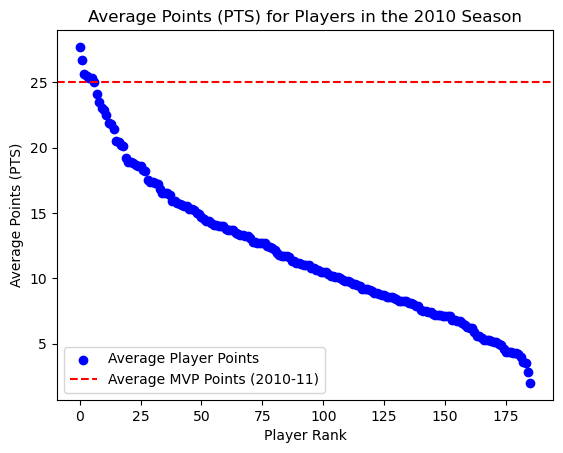

In [3]:
player_stats_2010 = player_stats_df[player_stats_df['SEASON'] == '2010-11']
mvp_stats_2010 = mvp_team_df[mvp_team_df['SEASON'] == '2010-11']

player_pts_2010 = player_stats_2010['PTS']

mvp_pts_2010 = mvp_stats_2010['PTS'].values[0]

plt.scatter(range(len(player_pts_2010)), player_pts_2010, label=\
            'Average Player Points', color='blue')
plt.axhline(y=mvp_pts_2010, color='red', linestyle='--',\
             label='Average MVP Points (2010-11)')
plt.title('Average Points (PTS) for Players in the 2010 Season')
plt.xlabel('Player Rank')
plt.ylabel('Average Points (PTS)')
plt.legend()
plt.show()

This plot aims to display the average points for the MVP over 20 seasons.

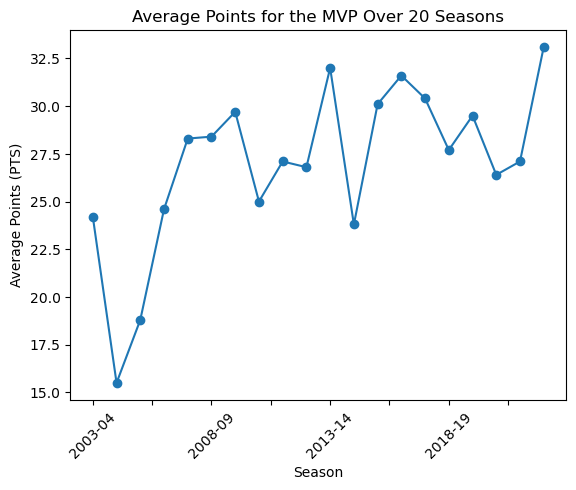

In [4]:
average_pts_mvp = mvp_team_df.groupby('SEASON')['PTS'].mean()

average_pts_mvp.plot(marker='o', linestyle='-')
plt.title('Average Points for the MVP Over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Average Points (PTS)')
plt.xticks(rotation=45)
plt.show()


This shows the average points by players over the years

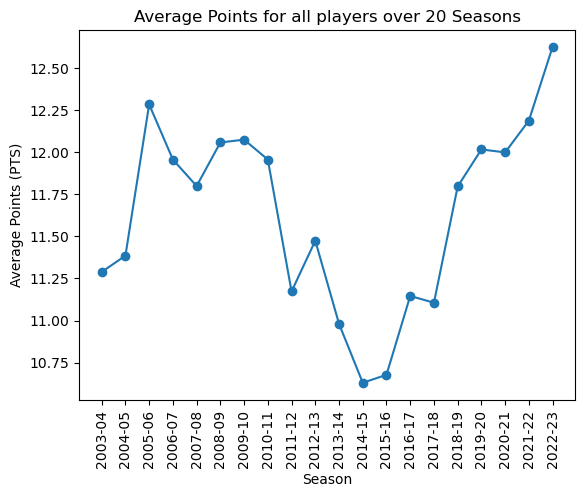

In [5]:
average_pts = player_stats_df.groupby('SEASON')['PTS'].mean()

plt.plot(average_pts, marker='o')
plt.title('Average Points for all players over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Average Points (PTS)')
plt.xticks(rotation=90)
plt.show()


This shows the average of all assists over 20 seasons 

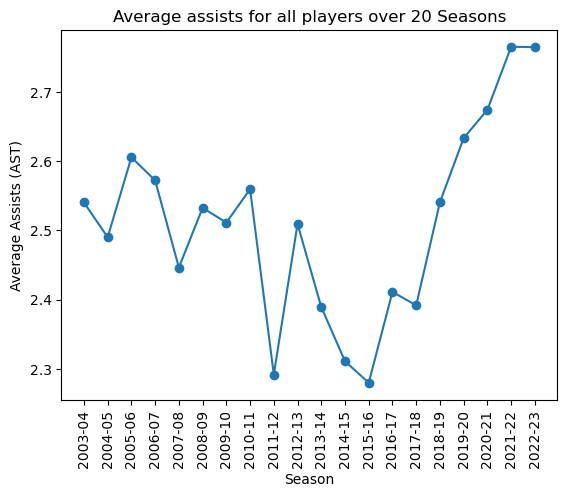

In [6]:
average_ast = player_stats_df.groupby('SEASON')['AST'].mean()

plt.plot(average_ast, marker='o')
plt.title('Average assists for all players over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Average Assists (AST)')
plt.xticks(rotation=90)
plt.show()


This aims to show the average age of players in the NBA over 20 years

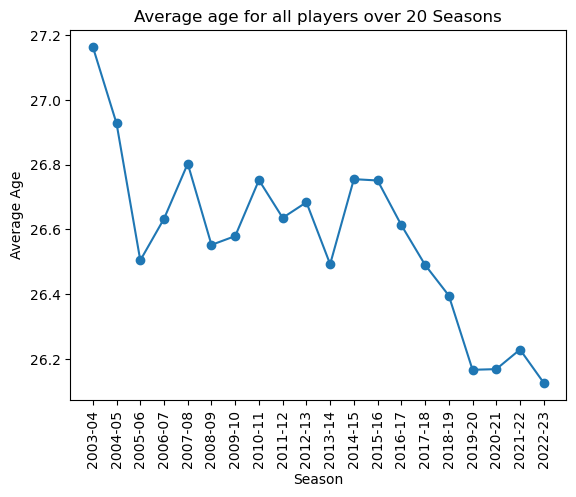

In [7]:
average_age = merged_df.groupby('SEASON')['Age'].mean()

plt.plot(average_age, marker='o')
plt.title('Average age for all players over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Average Age')
plt.xticks(rotation=90)
plt.show()


This aims to show the respective average percentage of points the mvp has on their team

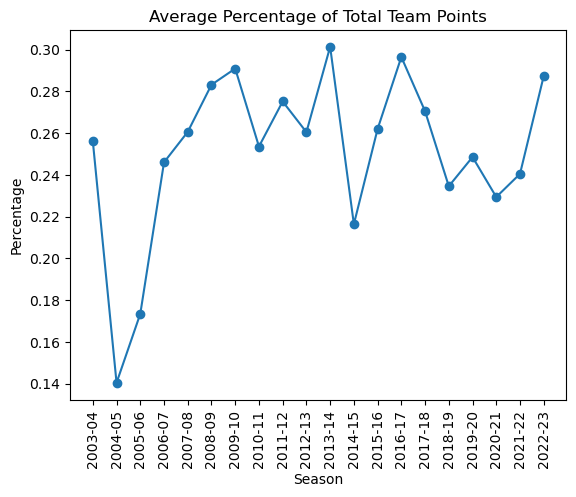

In [8]:
percentage_pts_team = mvp_teams_df['PTS']/mvp_teams_df['PTS_2']

plt.plot(mvp_teams_df['SEASON'], percentage_pts_team, marker='o')
plt.title('Average Percentage of Total Team Points')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()



This plots aims to show the average amount of wins for a team that has an mvp player vs the average nba team 

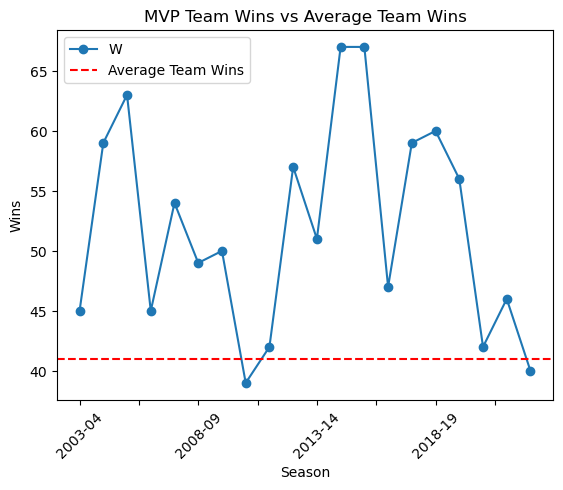

In [9]:
mvp_average_wins = mvp_teams_df.groupby('Season')['W'].mean()

mvp_average_wins.plot(marker='o')
plt.title('MVP Team Wins vs Average Team Wins')
#Always supposed to average out to 41 wins
plt.axhline(y=41, color='red', linestyle='--', label='Average Team Wins')
plt.xlabel('Season')
plt.xticks(rotation=45)
plt.ylabel('Wins')
plt.legend()
plt.show()

This plot aims to show the average points of an mvp team and an average team for 20 seasons

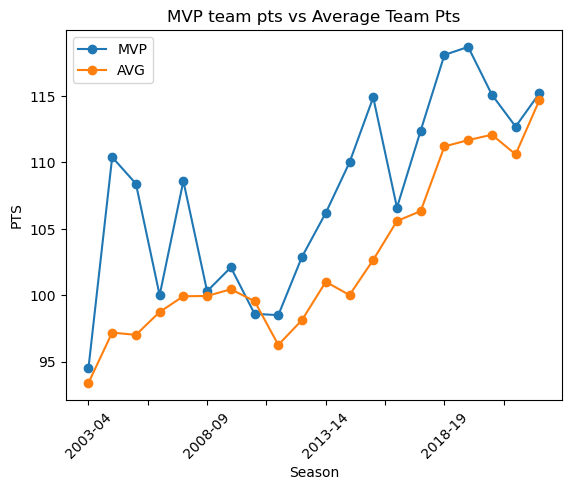

In [10]:
mvp_teams_df = duckdb.sql("SELECT * FROM mvp_team_df m LEFT JOIN \
    all_team_stats_df a ON m.FULL_NAME = a.TEAM AND m.SEASON = a.SEASON").df() 
mvp_average_pts = mvp_teams_df.groupby('Season')['PTS_2'].mean()

average_team_pts = all_team_stats_df.groupby('Season')['PTS'].mean()

mvp_average_pts.plot(marker='o')
average_team_pts.plot(marker='o')
plt.title('MVP team pts vs Average Team Pts')
plt.xlabel('Season')
plt.xticks(rotation=45)
plt.ylabel('PTS')
plt.legend(['MVP','AVG'])
plt.show()


Checking how many times there have been repeat MVP winners

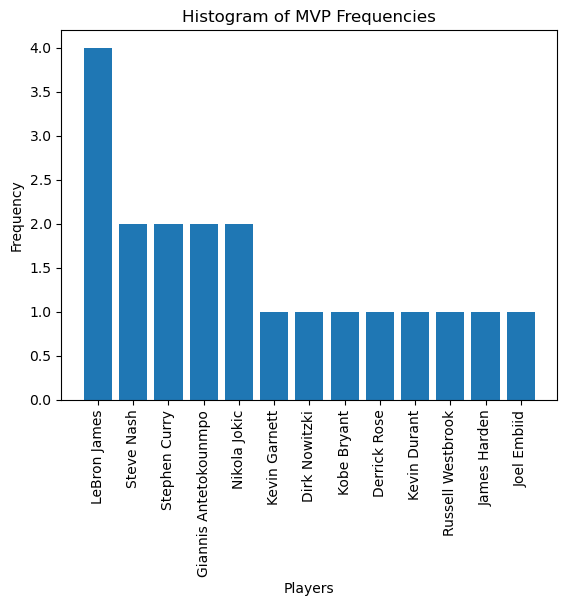

In [11]:
name_counts = mvp_teams_df['PLAYER'].value_counts()
plt.bar(name_counts.index, name_counts.values)
plt.xlabel('Players')
plt.ylabel('Frequency')
plt.title('Histogram of MVP Frequencies')
plt.xticks(rotation=90)
plt.show()


### B. Prediction Model

In [12]:
def Normalizer(x):
  scaler = preprocessing.StandardScaler().fit(x)
  return(scaler.transform(x))

In [13]:
columns = ['PLAYER', 'TEAM', 'FULL_NAME', 'SEASON', 'GP', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'EFF', 'Rk', 'Team',
       'G', 'MP', 'FG', 'FGA_2', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'FT', 'FTA_2', 'FT%', 'ORB', 'DRB', 'TRB', 'AST_2', 'STL_2', 'BLK_2',
       'TOV_2', 'PF', 'PTS_2', 'Age', 'W', 'L', 'Season']

In [14]:
from sklearn.metrics import accuracy_score

def predict_mvp(player, season):
  tmp = model_df[model_df["SEASON"] == season]
  columns_of_interest = ["PTS", "AST", "FG_PCT", "W", "FG3_PCT", "STL", "BLK"]
  mvp_train, mvp_test = train_test_split(tmp, test_size=0.2, random_state=2950)
  model = LogisticRegression()
  model.fit(Normalizer(mvp_train[columns_of_interest]), mvp_train["MVP"])

  player_data = model_df.loc[model_df["PLAYER"] == player]

  if player_data.empty:
      print(f"No data found for {player}.")
      return None
  player_stats = player_data[columns_of_interest].iloc[0]
  prediction = model.predict_proba([player_stats])
  # print(accuracy_score(prediction, mvp_test))
  return (f"{player} has a {prediction[0][1]*100}% chance of winning mvp for the {season} NBA season")


In [15]:
predict_mvp("LeBron James", "2016-17")
#Need to make changes to this so that it can take the mvp candidates into account as well as the vote shares that they get when calculating the probability of someone winning MVP

'LeBron James has a 99.99989964588654% chance of winning mvp for the 2016-17 NBA season'

### C. Hypothesis 1 Analysis

Hypothesis 1: The player with the most points per game on average during the season is more likely to win the award than other players.


For this analysis, we first created a dataframe consisting of the most relevant variables to this analysis (Player Name, Points Per Game, Season) from the existing dataframe player_stats_df. We also added another column to the dataframe, a binary variable "is_mvp" telling us whether or not that player had been nominated for the MVP award or not.
Then, we created the X and y variables for the logistic regression, ran the train_test_split to prevent overfitting and ran the Logistic Regression model. From this, we got the intercept and coefficient for points per game.
Lastly, we ran the Logit function to get the sigificance level of the prediction, which would tell us whether or not we should reject the null hypothesis.


In [17]:
points_per_game = duckdb.sql("""SELECT PLAYER, PTS, SEASON FROM player_stats_df""").df()
mvp_data = duckdb.sql("""SELECT PLAYER, PTS, SEASON FROM mvp_teams_df""").df()


is_mvp_df = pd.DataFrame({'PLAYER': [], 'PTS': [], 'SEASON': [], 'is_mvp': []})


for year in points_per_game['SEASON'].unique():
   ppg_year = points_per_game[points_per_game['SEASON'] == year].copy()
   mvp_players = mvp_data[mvp_data['SEASON'] == year]['PLAYER']
  
   ppg_year['is_mvp'] = np.where(ppg_year['PLAYER'].isin(mvp_players), 1, 0)
   is_mvp_df = pd.concat([is_mvp_df, ppg_year])


#is_mvp_df is basically a dataframe which has columns PLAYER, PTS, SEASON and a binary variable for whether or not this is an MVP candidate




X = is_mvp_df[['PTS']]
X = sm.add_constant(X)
y = is_mvp_df['is_mvp'].astype(int)


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2950)


# Logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


# Coefficients and intercept
coef = log_reg.coef_[0]
intercept = log_reg.intercept_[0]


print(f"Coefficient for points per game: {coef[0]}")
print(f"Intercept: {intercept}")


#Source: Lecture notes
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())



Coefficient for points per game: 0.0007628100313001192
Intercept: -12.507101202015582
Optimization terminated successfully.
         Current function value: 0.017503
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 is_mvp   No. Observations:                 4386
Model:                          Logit   Df Residuals:                     4384
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                  0.3991
Time:                        23:30:02   Log-Likelihood:                -76.768
converged:                       True   LL-Null:                       -127.76
Covariance Type:            nonrobust   LLR p-value:                 5.577e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.2608

### D. Hypothesis 2 Analysis


In [18]:
#wins_per_game is a dataframe consisting of the names of teams, wins per season and season name. this is repeated for each season.
wins_per_team = duckdb.sql("""SELECT Team, W, Season FROM all_team_stats_df""").df()


#mvp_data consists of a data frame with MVP name along with season they were MVP and the team they belonged to
mvp_data = duckdb.sql("""SELECT PLAYER, SEASON, FULL_NAME AS TEAM FROM mvp_teams_df""").df()


#this is an empty df to add each loop to
mvp_in_team_df = pd.DataFrame({'Team': [], 'W': [], 'Season': [], 'mvp_in_team': []})




#For "2003-04"
for year in wins_per_team['Season'].unique():
   #This slices wins_per_team to only loop over those teams that are in that year. This has a list of all teams in 2003-04
   wins_year = wins_per_team[wins_per_team['Season'] == year].copy()
   #This has the name of the team that the MVP belonged to
   mvp_team = mvp_data[mvp_data['SEASON'] == year]['TEAM']
  
   wins_year['mvp_in_team'] = np.where(wins_year['Team'].isin(mvp_team), 1, 0)
   mvp_in_team_df = pd.concat([mvp_in_team_df, wins_year])




X = mvp_in_team_df[['W']]
X = sm.add_constant(X)
y = mvp_in_team_df['mvp_in_team'].astype(int)




# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2950)




# Logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)




# Coefficients and intercept
coef = log_reg.coef_[0]
intercept = log_reg.intercept_[0]




print(f"Coefficient for wins per team: {coef[0]}")
print(f"Intercept: {intercept}")
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())


Coefficient for wins per team: 2.8146893015429383e-06
Intercept: -8.298536986285198
Optimization terminated successfully.
         Current function value: 0.128434
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            mvp_in_team   No. Observations:                  599
Model:                          Logit   Df Residuals:                      597
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                  0.1223
Time:                        23:30:38   Log-Likelihood:                -76.932
converged:                       True   LL-Null:                       -87.653
Covariance Type:            nonrobust   LLR p-value:                 3.647e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.9157   

## 5. Evolution of Significance


For Hypothesis 1: The significance level is 0, which is less than 0.05, thus we reject our null hypothesis. A higher points per game does not increase the likelihood of a player being nominated for the most valuable player.

## 6. Interpretation & Conclusions




### Hypothesis 1:
- A higher points per game does not increase the likelihood of a player being nominated for the most valuable player.
- The coefficient is 0.0007628100313001192, which means that for each additional point, a player is 1.00076310104 times more likely to receive the MVP award
- An average player makes about 12 points and an MVP makes 25 points per game. Thus, an MVP makes 13 more points than an average player. Thus, an MVP is 1.00996586213 times as likely to get the MVP as compared to an average player.
- The prediction seems odd, given that an average player is almost as likely as an average player to get an MVP award. This may be because there are multiple factors that contribute to someone becoming an MVP, and perhaps a multivariable regression would be more apt.


## 7. Limitations

The dataset scraped and built for the project encompasses a comprehensive collection of statistics and historical records spanning the past 20 seasons of the NBA including specifics about players and teams as well as the historical records of who received the MVP award for the past 20 seasons. It is a set that will be a resource for us when we aim to build a predictive model to estimate the probability of a player receiving the MVP award in future seasons. This dataset comprises various types of information, including individual player statistics, team statistics, and records of MVP winners, offering a multi-faceted view of the league's performance dynamics.

While this dataset has a lot of quality data that has been carefully collected and cleaned, it is not without its limitations. One notable challenge is data quality, where missing values and errors could potentially affect the integrity of the analyses. In the collection and cleaning process, we were sure to address this the best we could. Moreover, the data may be influenced by selection biases, as MVP awards can be influenced by non-statistical factors, such as media attention and player popularity. The dataset's relatively small sample size of MVPs compared to the total player population can present statistical challenges. Furthermore, it is essential to consider the evolving nature of the game, encompassing rule changes, shifts in playing style, and variations in MVP selection criteria, which the dataset might not fully encapsulate. There also is consideration not addressed for player injuries, retirements, team trades, and other insights that might be at play in the selection process. That being said, our data also covers the time during the pandemic when fewer games were played and the regular seasons were interrupted. Given the relatively small number of MVPs each season, there is a risk of overfitting the model to historical MVPs, making it less applicable for predicting future MVPs. Also, if player statistics are highly correlated, this can lead to multicollinearity issues when building predictive models. This can make it challenging to determine which individual statistics truly contribute to MVP selection. 

## 9. Appendix

Please see the following in our GitHub repository:
- appendix.ipynb - for data collection and cleaning description
- See the appendix folder for all of the '.csv' files used in our project